### Importazione librerie

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
btc_ohlcv = pd.read_csv('Bitcoin futures (USDT) 25-03-2020-10-36-00_03-05-2025-00-00-00 timeframe 1m.csv')
btc_ohlcv.set_index('timestamp', inplace=True)
btc_ohlcv.index = pd.to_datetime(btc_ohlcv.index)
btc_ohlcv

,open,high,low,close,volume
timestamp,,,,,
2020-03-25 10:36:00,6500.0,6500.0,6500.0,6500.0,0.001
2020-03-25 10:37:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:38:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:39:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:40:00,6500.0,6500.0,6500.0,6500.0,0.000
...,...,...,...,...,...
2025-05-02 23:56:00,96789.9,96796.9,96789.9,96796.9,9.169
2025-05-02 23:57:00,96796.9,96840.0,96796.9,96831.7,42.991
2025-05-02 23:58:00,96831.7,96833.5,96831.6,96833.5,11.743


In [16]:
btc_ohlcv = btc_ohlcv.iloc[-60*24*30:]
btc_ohlcv

,open,high,low,close,volume
timestamp,,,,,
2025-04-03 00:01:00,82470.8,82473.2,82359.8,82369.9,75.205
2025-04-03 00:02:00,82369.9,82422.0,82338.0,82401.1,113.696
2025-04-03 00:03:00,82401.1,82412.8,82143.0,82148.1,394.304
2025-04-03 00:04:00,82148.1,82294.9,82107.1,82280.0,446.658
2025-04-03 00:05:00,82280.0,82529.0,82266.4,82529.0,356.019
...,...,...,...,...,...
2025-05-02 23:56:00,96789.9,96796.9,96789.9,96796.9,9.169
2025-05-02 23:57:00,96796.9,96840.0,96796.9,96831.7,42.991
2025-05-02 23:58:00,96831.7,96833.5,96831.6,96833.5,11.743


### Simulazione

In [17]:
def simulate_value_averaging_modified(
    btc_ohlcv: pd.DataFrame,
    timeframe: int,
    aumento_obiettivo: float,
    tp: float,
    compra_pure: bool,
    initial_cash: float,
    obiettivo_percentuale: bool = False
) -> pd.DataFrame:
    """
    Simula una strategia di "value averaging" modificato su dati OHLCV di Bitcoin.

    Parametri:
    - btc_ohlcv: DataFrame con indice datetime e colonne ['open','high','low','close','volume']
    - timeframe: numero di minuti tra ogni valutazione della strategia
    - aumento_obiettivo: incremento (in USDT o in percentuale della liquidità) dell'obiettivo per ogni periodo
    - tp: take profit in percentuale (es. 0.02 = 2%)
    - compra_pure: se True, compra con tutta la liquidità residua se non sufficiente per raggiungere l'obiettivo
    - initial_cash: liquidità iniziale in USDT
    - obiettivo_percentuale: se True, interpreta aumento_obiettivo come percentuale (0 < aumento_obiettivo < 1) della liquidità attuale da usare come base per l'incremento dell'obiettivo

    Ritorna:
    DataFrame indicizzato per timestamp con colonne:
    ['prezzo', 'azione', 'valore_bitcoin', 'liquidità', 'portafoglio_totale']
    """
    # Validazione parametro obiettivo_percentuale
    if obiettivo_percentuale and not (0 < aumento_obiettivo < 1):
        raise ValueError("Quando obiettivo_percentuale è True, aumento_obiettivo deve essere tra 0 e 1")

    cash = initial_cash
    crypto = 0.0
    sum_spent = 0.0
    sum_btc = 0.0
    steps = 0
    base_increment = aumento_obiettivo if not obiettivo_percentuale else initial_cash * aumento_obiettivo
    records = []

    for timestamp, row in btc_ohlcv.iterrows():
        price = row['close']
        action = 'niente'
        steps += 1

        if steps % timeframe == 0:
            period = steps // timeframe
            # Calcolo incremento obiettivo per questo ciclo
            if obiettivo_percentuale and (sum_btc == 0 and period == 1 or action == 'vendita'):
                base_increment = cash * aumento_obiettivo
            objective = period * base_increment

            current_value = crypto * price
            avg_price = sum_spent / sum_btc if sum_btc > 0 else None

            # Vendita se prezzo >= avg_price * (1 + tp)
            if crypto > 0 and avg_price is not None and price >= avg_price * (1 + tp):
                proceeds = crypto * price
                cash += proceeds
                crypto = 0.0
                sum_spent = 0.0
                sum_btc = 0.0
                steps = 0  # reset ciclo dopo vendita
                action = 'vendita'

            else:
                # Acquisto se primo acquisto o prezzo < avg_price
                if avg_price is None or price < avg_price:
                    needed = objective - current_value
                    if needed > 0:
                        if cash >= needed:
                            spend = needed
                            action = 'acquisto'
                        elif compra_pure and cash > 0:
                            spend = cash
                            action = 'acquisto'
                        else:
                            spend = 0.0
                            action = 'niente (tentato acquisto)'

                        if spend > 0:
                            amount = spend / price
                            crypto += amount
                            cash -= spend
                            sum_spent += spend
                            sum_btc += amount

        total = cash + crypto * price
        records.append({
            'timestamp': timestamp,
            'prezzo': price,
            'azione': action,
            'valore_bitcoin': crypto * price,
            'liquidità': cash,
            'portafoglio_totale': total
        })

    result = pd.DataFrame(records).set_index('timestamp')
    return result

In [ ]:
def plot_equity_with_hold(sim_results: pd.DataFrame, btc_ohlcv: pd.DataFrame, initial_cash: float):
    """
    Stampa il grafico della equity line della strategia e il confronto con la linea di "hold".

    Parametri:
    - sim_results: DataFrame restituito da simulate_value_averaging_modified
    - btc_ohlcv: DataFrame OHLCV originale
    - initial_cash: liquidità iniziale (per calcolare hold)
    """
    # Equity della strategia
    equity = sim_results['portafoglio_totale']

    # Equity di hold: compra all'inizio e tieni fino alla fine
    first_price = btc_ohlcv['close'].iloc[0]
    btc_amount = initial_cash / first_price
    hold_equity = btc_amount * btc_ohlcv['close']

    plt.figure(figsize=(12, 6))
    plt.plot(equity.index, equity.values, label='Strategia Value Averaging modificata')
    plt.plot(hold_equity.index, hold_equity.values, label='Hold BTC', linestyle='--')
    plt.xlabel('Timestamp')
    plt.ylabel('Valore Portafoglio (USDT)')
    plt.title('Equity Line: Strategia vs Hold')
    plt.legend()
    plt.grid()
    plt.show()

In [32]:
# Simula
transactions = simulate_value_averaging_modified(
    btc_ohlcv=btc_ohlcv,
    timeframe=60,
    aumento_obiettivo=10,
    tp=0.05,
    compra_pure=True,
    initial_cash=1000.0,
    obiettivo_percentuale=False
)

transactions

,prezzo,azione,valore_bitcoin,liquidità,portafoglio_totale
timestamp,,,,,
2025-04-03 00:01:00,82369.9,niente,0.000000,1000.000000,1000.000000
2025-04-03 00:02:00,82401.1,niente,0.000000,1000.000000,1000.000000
2025-04-03 00:03:00,82148.1,niente,0.000000,1000.000000,1000.000000
2025-04-03 00:04:00,82280.0,niente,0.000000,1000.000000,1000.000000
2025-04-03 00:05:00,82529.0,niente,0.000000,1000.000000,1000.000000
...,...,...,...,...,...
2025-05-02 23:56:00,96796.9,niente,30.253727,1041.720457,1071.974184
2025-05-02 23:57:00,96831.7,niente,30.264604,1041.720457,1071.985061
2025-05-02 23:58:00,96833.5,niente,30.265166,1041.720457,1071.985624


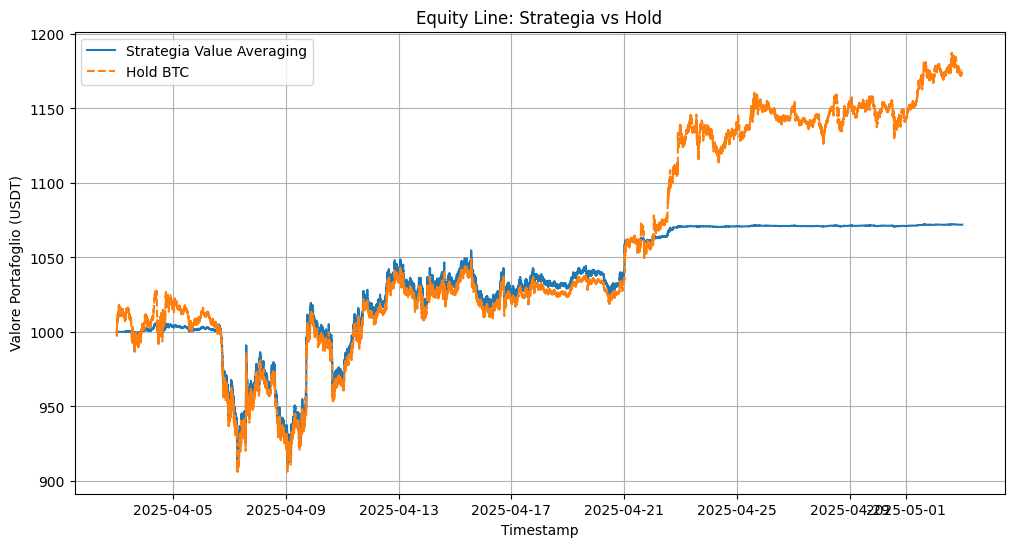

In [33]:
# Grafico
plot_equity_with_hold(transactions, btc_ohlcv, initial_cash=1000.0)

In [34]:
transactions['azione'].value_counts()

azione
niente                       43075
niente (tentato acquisto)       92
acquisto                        30
vendita                          3
Name: count, dtype: int64